<a href="https://colab.research.google.com/github/WanNazme/DLIVACV_Assigments/blob/main/Assessment1_DeepLearning_WanNazme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a pretty girl who is choosing a dress for Hari Raya. It turns out that the girl is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue, font-family: Times New Roman">
    Cross entropy loss function will be the most appropriate to use. It is optimized for multi class classification. It measures the performance of a classification model whose output is a probability value between 0 and 1 which can describe how likely a model is and the error function of each data point.

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    

<div>
<img src="https://vitalflux.com/wp-content/uploads/2021/11/VGG16-CNN-Architecture.png" width="550"/>
</div>


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UmNQUaFcoH9Ex2TGbrzT")
project = rf.workspace("popular-benchmarks").project("fashion-mnist-ztryt")
dataset = project.version(1).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/Fashion-MNIST-1 in folder:: 100%|██████████| 68367/68367 [00:09<00:00, 7592.00it/s]


In [6]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary


###############################################
######## THE REST OF YOUR CODES HERE ##########
###############################################

In [7]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=224),
        transforms.Resize(size=200),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        
        # transforms.CenterCrop(size=224),
        transforms.Resize(size=200),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# !rm -rf /content/Fashion-MNIST-3/test/ankle_boot
# !rm -rf /content/Fashion-MNIST-3/test/bag

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
dataset = '/content/datasets/Fashion-MNIST-1'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

10


In [ ]:
# batch_size = 4


# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('coat', 'dress', 'pullover', 'sandal',
#        'shirt', 'sneaker', 'trouser', 'tshirt_top')

In [11]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=batchSize, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=batchSize, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

58568
9775


In [12]:
#1. DEFINE THE CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3) 
        self.conv2 = nn.Conv2d(6, 12, 3) 
        self.conv3 = nn.Conv2d(12, 24, 3)
        self.conv4 = nn.Conv2d(24, 48, 3) 
        self.conv5 = nn.Conv2d(48, 96, 3)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(96 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 24)
        self.fc3 = nn.Linear(24, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        # print(x.shape)
       
        x = x.view(-1, 96 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

In [13]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 198, 198]             168
              ReLU-2          [-1, 6, 198, 198]               0
         MaxPool2d-3            [-1, 6, 99, 99]               0
            Conv2d-4           [-1, 12, 97, 97]             660
              ReLU-5           [-1, 12, 97, 97]               0
         MaxPool2d-6           [-1, 12, 48, 48]               0
            Conv2d-7           [-1, 24, 46, 46]           2,616
              ReLU-8           [-1, 24, 46, 46]               0
         MaxPool2d-9           [-1, 24, 23, 23]               0
           Conv2d-10           [-1, 48, 21, 21]          10,416
             ReLU-11           [-1, 48, 21, 21]               0
        MaxPool2d-12           [-1, 48, 10, 10]               0
           Conv2d-13             [-1, 96, 8, 8]          41,568
             ReLU-14             [-1, 9

In [14]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'CNN_model_'+str(epoch)+'.pt')
            
    return model, history

In [15]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.1558, Accuracy: 20.5658%, 
		Validation : Loss : 1.4468, Accuracy: 50.7519%, Time: 133.6851s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.2160, Accuracy: 58.1205%, 
		Validation : Loss : 1.0376, Accuracy: 60.6343%, Time: 130.9641s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.9438, Accuracy: 63.9650%, 
		Validation : Loss : 0.9139, Accuracy: 64.6752%, Time: 130.6966s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.8498, Accuracy: 66.7907%, 
		Validation : Loss : 0.8437, Accuracy: 67.2123%, Time: 131.1261s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.8073, Accuracy: 68.2847%, 
		Validation : Loss : 0.8177, Accuracy: 68.1125%, Time: 131.2014s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.7827, Accuracy: 68.8567%, 
		Validation : Loss : 0.8064, Accuracy: 68.0409%, Time: 130.1435s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.7622, Accuracy: 69.5841%, 
		Validation : Loss : 0.8489, Accuracy: 66.9054%, Time: 130.0816s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.7482,

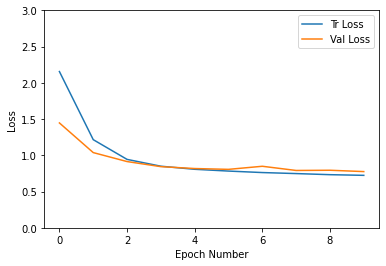

In [16]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

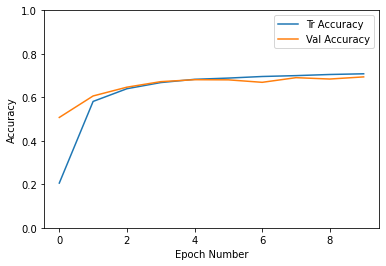

In [17]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [18]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [19]:
model_pm = models.resnet18(pretrained=True)
num_ftrs = model_pm.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_pm.fc = nn.Linear(num_ftrs, 10)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pm.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_pm.to(device)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model_pm, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.3435, Accuracy: 88.1044%, 
		Validation : Loss : 0.2282, Accuracy: 91.7136%, Time: 247.8136s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.1981, Accuracy: 92.9057%, 
		Validation : Loss : 0.1991, Accuracy: 92.8491%, Time: 247.4064s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.1566, Accuracy: 94.3399%, 
		Validation : Loss : 0.1998, Accuracy: 92.6854%, Time: 247.9828s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1235, Accuracy: 95.5436%, 
		Validation : Loss : 0.2273, Accuracy: 92.2455%, Time: 247.0803s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.0981, Accuracy: 96.4230%, 
		Validation : Loss : 0.1944, Accuracy: 93.3811%, Time: 248.1340s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.0732, Accuracy: 97.4696%, 
		Validation : Loss : 0.2328, Accuracy: 92.7468%, Time: 246.9301s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0535, Accuracy: 98.1543%, 
		Validation : Loss : 0.2219, Accuracy: 93.2379%, Time: 249.4900s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0387,

In [21]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_pm(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 93 %


d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are: Batch normalization and dropout. </span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [22]:
#1. DEFINE THE CNN 
class CNN_MC(nn.Module):

    def __init__(self):
        super(CNN_MC, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3) 
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, 3) 
        self.conv3 = nn.Conv2d(12, 24, 3)
        self.conv4 = nn.Conv2d(24, 48, 3) 
        self.conv5 = nn.Conv2d(48, 96, 3)
        self.batchnorm2 = nn.BatchNorm2d(96)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(96 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 24)
        self.fc3 = nn.Linear(24, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.batchnorm1(self.pool(self.relu(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.batchnorm2(self.pool(self.relu(self.conv5(x))))
        # print(x.shape)
       
        x = x.view(-1, 96 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        
        return x

In [23]:
model_pm = CNN_MC() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pm.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_pm.to(device)
summary(model_pm, (3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 198, 198]             168
              ReLU-2          [-1, 6, 198, 198]               0
         MaxPool2d-3            [-1, 6, 99, 99]               0
       BatchNorm2d-4            [-1, 6, 99, 99]              12
            Conv2d-5           [-1, 12, 97, 97]             660
              ReLU-6           [-1, 12, 97, 97]               0
         MaxPool2d-7           [-1, 12, 48, 48]               0
            Conv2d-8           [-1, 24, 46, 46]           2,616
              ReLU-9           [-1, 24, 46, 46]               0
        MaxPool2d-10           [-1, 24, 23, 23]               0
           Conv2d-11           [-1, 48, 21, 21]          10,416
             ReLU-12           [-1, 48, 21, 21]               0
        MaxPool2d-13           [-1, 48, 10, 10]               0
           Conv2d-14             [-1, 9

In [24]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model_pm, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.2697, Accuracy: 54.4803%, 
		Validation : Loss : 0.6893, Accuracy: 73.6061%, Time: 133.8567s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.7078, Accuracy: 73.9055%, 
		Validation : Loss : 0.6057, Accuracy: 76.2558%, Time: 137.4599s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.6205, Accuracy: 76.9277%, 
		Validation : Loss : 0.5662, Accuracy: 78.4246%, Time: 135.5592s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.5790, Accuracy: 78.3602%, 
		Validation : Loss : 0.5366, Accuracy: 79.2225%, Time: 133.5023s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.5462, Accuracy: 79.5469%, 
		Validation : Loss : 0.5036, Accuracy: 80.3581%, Time: 134.6563s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.5285, Accuracy: 80.0625%, 
		Validation : Loss : 0.5051, Accuracy: 80.1228%, Time: 133.7918s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.5112, Accuracy: 80.5918%, 
		Validation : Loss : 0.4986, Accuracy: 80.3990%, Time: 134.9961s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.4973,

In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_pm(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 81 %


f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    No accuracy improvement if compared to the pre-trained model but if compared to the model in question (b), the accuracy improved significantly. This may due to because pre-trained model requires less training compared to CNN model</span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
    Resize the data and Rotation or flip the images. </span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [26]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=200, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=200),
        transforms.Resize(size=200),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(size=200, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=200),
        transforms.Resize(size=200),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [27]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model_pm, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.4554, Accuracy: 82.5382%, 
		Validation : Loss : 0.4947, Accuracy: 80.9821%, Time: 132.1522s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4440, Accuracy: 82.7790%, 
		Validation : Loss : 0.5020, Accuracy: 80.9514%, Time: 132.2826s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4335, Accuracy: 83.2588%, 
		Validation : Loss : 0.4938, Accuracy: 81.1458%, Time: 141.1304s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4290, Accuracy: 83.3851%, 
		Validation : Loss : 0.5041, Accuracy: 81.0946%, Time: 137.4258s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4189, Accuracy: 83.6566%, 
		Validation : Loss : 0.4988, Accuracy: 81.2788%, Time: 133.6067s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.4067, Accuracy: 84.1210%, 
		Validation : Loss : 0.5223, Accuracy: 81.0026%, Time: 133.3092s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3965, Accuracy: 84.4096%, 
		Validation : Loss : 0.5134, Accuracy: 81.2685%, Time: 133.1140s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3931,

In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_pm(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 81 %


**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

In [1]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12975, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 12975 (delta 82), reused 99 (delta 60), pack-reused 12844
Receiving objects: 100% (12975/12975), 13.04 MiB | 18.25 MiB/s, done.
Resolving deltas: 100% (8915/8915), done.
/content/yolov5
     |████████████████████████████████| 1.6 MB 42.3 MB/s 
     |████████████████████████████████| 145 kB 20.9 MB/s 
     |████████████████████████████████| 178 kB 9.4 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 138 kB 59.2 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PwOxSxv9VldBOvF5pM8C")
project = rf.workspace("hafizi-malik-xzwz5").project("masked-face-recognition-vgbqp")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to masked-face-recognition-1 in yolov5pytorch:: 100%|██████████| 302/302 [00:00<00:00, 1381.62it/s]


In [3]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [4]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/yolov5/masked-face-recognition-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-180-g82bec4c Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=